## Sep Tutorial for NGC

Import necessary libraries:

In [1]:
import numpy as np
import sep 
import astropy

Import plotting/fits handling tools, set default figure size

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Open FITS file, and load the Header/Data list (gives access to image data)

In [3]:
hdul = astropy.io.fits.open("jw02731-o001_t017_nircam_clear-f090w_i2d.fits")

Extract image data and display it with contrast/grayscale excluding NaNs

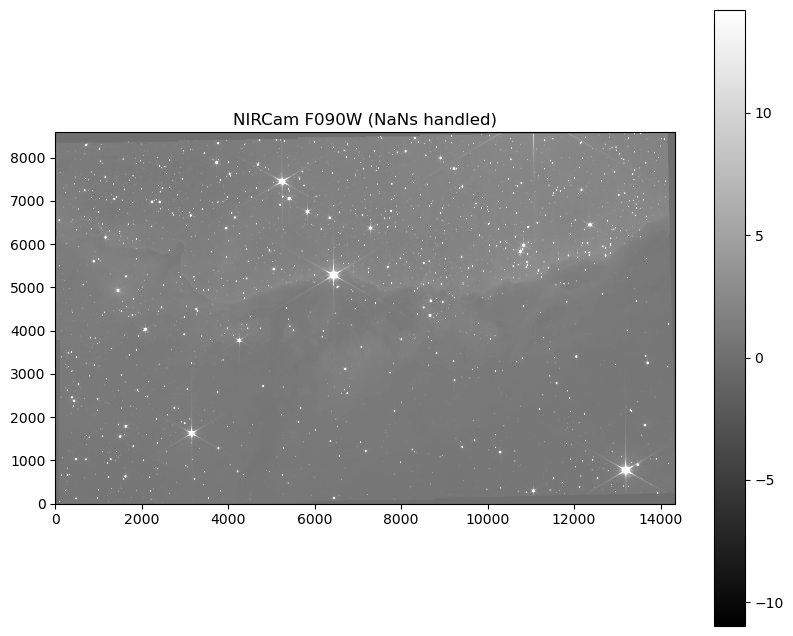

In [4]:

data = hdul['SCI'].data
data = np.array(data, dtype=np.float32)  
data[np.isnan(data)] = 0  


finite_vals = data[np.isfinite(data)]
m, s = np.mean(finite_vals), np.std(finite_vals)

# Plot
plt.figure()
plt.imshow(data, cmap='gray', vmin=m - s, vmax=m + s, origin='lower')
plt.colorbar()
plt.title("NIRCam F090W (NaNs handled)")
plt.show()

Estimate how to model the background using SEP

In [5]:

bkg = sep.Background(data)

Print global background stats: <br>
globalback: average backgorund level of the image <br>
globalrms: root-mean-square of the background (noise estimate)

In [6]:

print(bkg.globalback)
print(bkg.globalrms)

1.1717956066131592
0.0637655034661293


generate a 2D model of the backgroudn

In [7]:

bkg_image = bkg.back()

plot the background

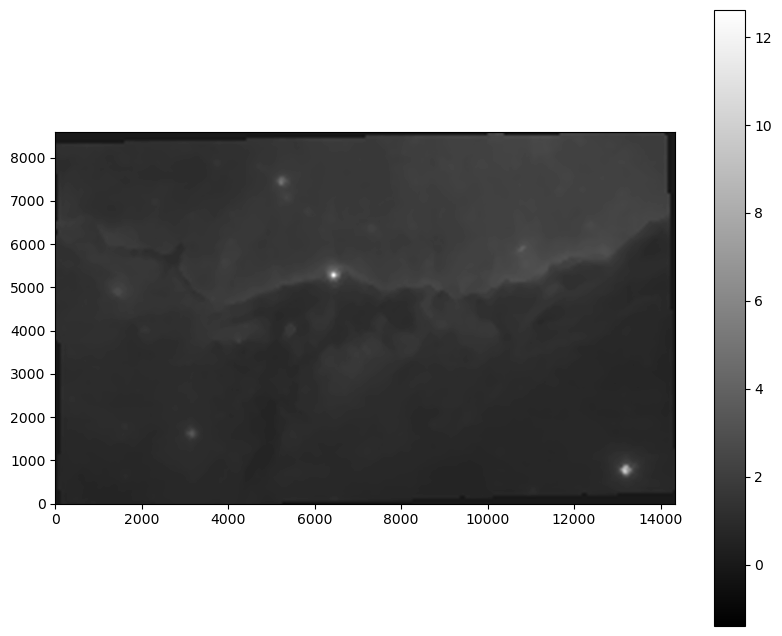

In [8]:

plt.figure()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("fitsimage2.png")
plt.show()

generate the noise map

In [9]:

bkg_rms = bkg.rms()

plot the noise map

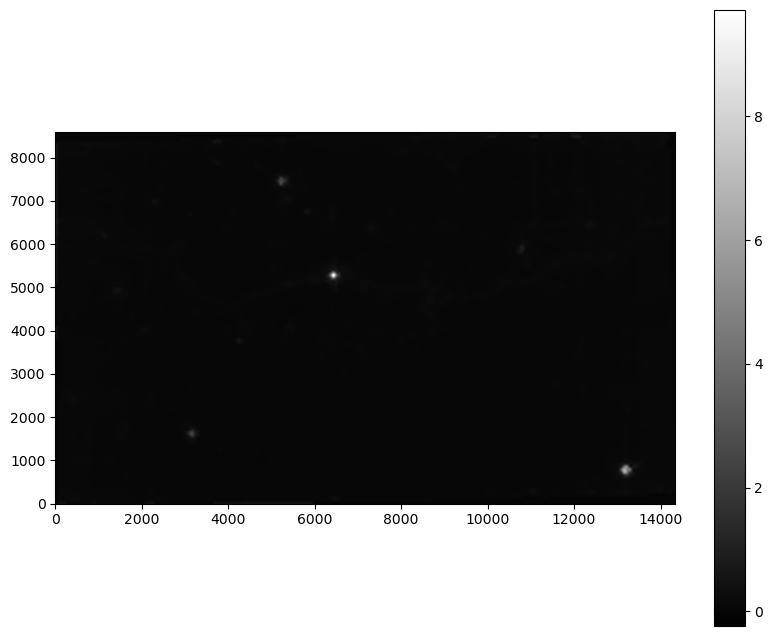

In [10]:

plt.figure()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("fitsimage3.png")
plt.show()

subtract background from image

In [11]:

data_sub = data - bkg


Find the number of objects <br>
where 1.5 is the detection threshold in rms<br>
and err=bkg.globalrms uses global rms as the noise estimate

In [12]:
sep.set_extract_pixstack(10_000_000)
objects = sep.extract(data_sub, 5.0, err=bkg.globalrms)

returns number of objects detected <br>
## 15459 sources

In [13]:

len(objects)

15459

In [14]:
fluxes = objects['flux']

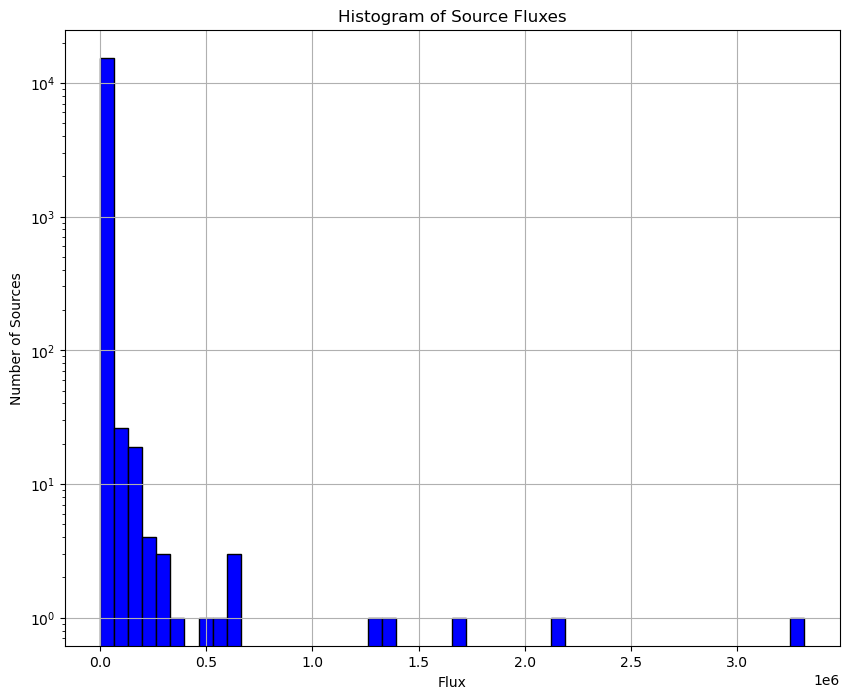

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(fluxes, bins=50, histtype='bar', color='blue', edgecolor= 'black')
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.title("Histogram of Source Fluxes")
plt.yscale('log')  # log scale for fainter sources
plt.grid(True)
plt.savefig("flux_histogram.png")
plt.show()

plot the image witht the background subtracted and the detected objects highlighted

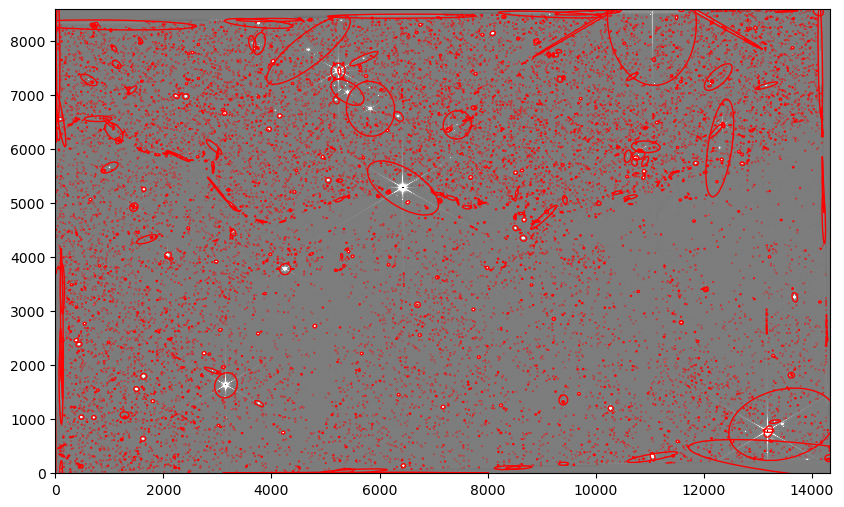

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig("NGCimage4.png")
plt.show()

Flux Mean = 2374.674 <br>
Flux Median = 30.979 <br>
Flux STD = 40430.224

## Flux calculations

In [17]:
flux_mean = np.mean(fluxes)
flux_median = np.median(fluxes)
flux_std = np.std(fluxes)
print(flux_mean, flux_median, flux_std)

2374.6741481629465 30.978961944580078 40430.22358016843


In [18]:
max_flux = np.max(fluxes)
max_index = np.argmax(fluxes)


Reproject from github

In [19]:
x_max = objects['x'][max_index]
y_max = objects['y'][max_index]
sigma_deviation = (max_flux - flux_mean) / flux_std


In [20]:
print(f"Largest flux value: {max_flux}")
print(f"Location in image: x = {x_max:.2f}, y = {y_max:.2f}")
print(f"{sigma_deviation:.2f} standard deviations above the mean")


Largest flux value: 3316464.0
Location in image: x = 6434.18, y = 5278.74
81.97 standard deviations above the mean


In [21]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = 'jw02731-o001_t017_nircam_clear-f090w_i2d.fits'
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = 'jw02731-o001_t017_nircam_clear-f187n_i2d.fits'
fname2 = 'jw02731-o001_t017_nircam_clear-f200w_i2d.fits'
fname3 = 'jw02731-o001_t017_nircam_clear-f335m_i2d.fits'
fname4 = 'jw02731-o001_t017_nircam_clear-f444w_i2d.fits'
fname5 = 'jw02731-o001_t017_nircam_f444w-f470n_i2d.fits'

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


# false color version of image <br>
combines info from jw02731-o001_t017_nircam_clear-f444w_i2d.fits, jw02731-o001_t017_nircam_clear-f200w_i2d.fits, and jw02731-o001_t017_nircam_clear-f090w_i2d.fits for the filters <br>
uses z-scale normalization for contrast. 

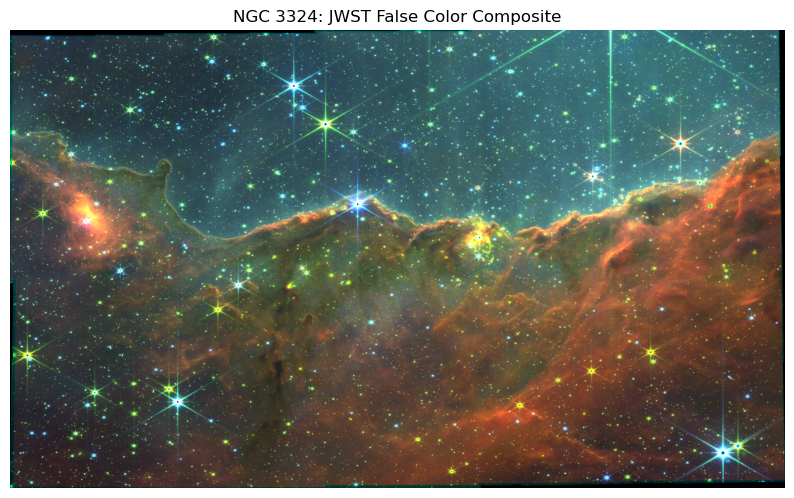

In [22]:

from astropy.visualization import ZScaleInterval
from reproject import reproject_interp


red_hdu = fits.open('jw02731-o001_t017_nircam_clear-f444w_i2d.fits')['SCI']
red_data, red_header = red_hdu.data, red_hdu.header


green_hdu = fits.open('jw02731-o001_t017_nircam_clear-f200w_i2d.fits')['SCI']
blue_hdu  = fits.open('jw02731-o001_t017_nircam_clear-f090w_i2d.fits')['SCI']

green_reproj, _ = reproject_interp((green_hdu.data, green_hdu.header), red_header)
blue_reproj, _  = reproject_interp((blue_hdu.data, blue_hdu.header), red_header)

def normalize(stamp):
    arr = np.nan_to_num(stamp, nan=0.0)
    lo, hi = ZScaleInterval().get_limits(arr)
    return np.clip((arr - lo) / (hi - lo), 0, 1)

R = normalize(red_data)
G = normalize(green_reproj)
B = normalize(blue_reproj)


rgb = np.dstack([R, G, B])

plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.title("NGC 3324: JWST False Color Composite")
plt.savefig('ngc3324_false_color.png', dpi=300, bbox_inches='tight')
plt.show()
